In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

: 

In [237]:
zaitra_folder = '/content/drive/MyDrive/Colab Notebooks/ZAITRA'
data_folder = '/content/drive/MyDrive/Colab Notebooks/ZAITRA/DATA'

image_patches_dir ='/content/drive/MyDrive/Colab Notebooks/ZAITRA/DATA/images_patches'
mask_patches_dir = '/content/drive/MyDrive/Colab Notebooks/ZAITRA/DATA/masks_patches'

assert len(os.listdir(mask_patches_dir)) == len(os.listdir(image_patches_dir)), 'mismatch!'

image_patches = np.array(sorted([os.path.join(image_patches_dir,x ) for x in os.listdir(image_patches_dir)]))
mask_patches = np.array(sorted([os.path.join(mask_patches_dir, x) for x in os.listdir(mask_patches_dir)]))

#image_patches = image_patches[:100] 
#mask_patches = mask_patches[:100] 

assert len(image_patches) == len(mask_patches), 'mismatch!'

# Train Test Split

In [238]:
from sklearn.model_selection import train_test_split


total_idxs = np.arange(len(image_patches))
train_idxs, val_idxs = train_test_split(total_idxs, train_size = 0.6)
val_idxs, test_idxs = train_test_split(val_idxs, train_size = 0.5)

train_images = image_patches[train_idxs]
val_images = image_patches[val_idxs]
test_images = image_patches[test_idxs]

train_masks = mask_patches[train_idxs]
val_masks = mask_patches[val_idxs]
test_masks = mask_patches[test_idxs]

assert len(train_images) == len(train_masks), 'mismatch!'
assert len(val_images) == len(val_masks), 'mismatch!'
assert len(test_images) == len(test_masks), 'mismatch!'
assert len(train_images) + len(val_images) + len(val_images) == 8208, 'tot mismatch!'  

In [239]:
from torchvision import transforms

def get_train_transforms():
  return transforms.Compose([
      transforms.ToPILImage(),
      transforms.RandomHorizontalFlip(p = 0.5),
      transforms.RandomVerticalFlip(p = 0.5),
      transforms.RandomRotation(degrees = 30),
      transforms.ToTensor(),
      transforms.Normalize(
          [0.485, 0.456, 0.406, 0.5], 
          [0.229, 0.224, 0.225, 0.5])
              ])
      #transforms.ToPILImage(),
  

def get_val_transforms():
  return transforms.Compose([
      transforms.ToPILImage(),
      transforms.ToTensor(),
      transforms.Normalize(
          [0.485, 0.456, 0.406, 0.5], 
          [0.229, 0.224, 0.225, 0.5])
              ])
      #transforms.ToPILImage(),
  
  
train_transform = get_train_transforms() 
val_transform = get_val_transforms()

In [242]:
import cv2
from torch.utils.data import Dataset
import torch

class SegmentationDataset(Dataset):
  def __init__(self, imagePaths, maskPaths, transforms):
    self.imagePaths = imagePaths
    self.maskPaths = maskPaths
    self.transforms = transforms
  
  def __len__(self):
    return len(self.imagePaths)
  
  def __getitem__(self, idx):
    imagePath = self.imagePaths[idx]
    image = np.load(imagePath)
    image = torch.from_numpy(image).permute(2,0,1)
    
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = np.load(self.maskPaths[idx])
    mask = torch.from_numpy(mask)
    print(mask)
    #mask = mask.type(torch.uint8)

    if self.transforms is not None:
      image = self.transforms(image)
      mask = self.transforms(mask)

    return {
        'imagePath': imagePath,
        'maskPath':self.maskPaths[idx],
        'image':image,
        'mask':mask.unsqueeze(0)
    }

In [249]:
torch.zeros(224,224)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])
/content/drive/MyDrive/Colab Notebooks/ZAITRA/DATA/images_patches/img_88_patch_6.npy
/content/drive/MyDrive/Colab Notebooks/ZAITRA/DATA/masks_patches/mask_88_patch_6.npy
torch.Size([4, 224, 224])
torch.Size([1, 224, 224])


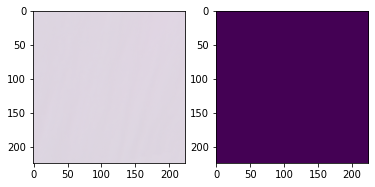

In [251]:
train_dataset = SegmentationDataset(train_images, train_masks, None)
test_dataset = SegmentationDataset(val_images, val_masks, None)

sample = train_dataset[15]

print(sample['imagePath'])
print(sample['maskPath'])

print(sample["image"].shape)
print(sample["mask"].shape)

plt.subplot(1,2,1)
plt.imshow(sample["image"].permute(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
#plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.imshow(torch.zeros(224,224))
plt.show()


In [222]:
from torch.utils.data import DataLoader

def get_dataloaders():
  train_dataset = SegmentationDataset(train_images, train_masks, None)
  val_dataset = SegmentationDataset(val_images, test_masks, None)
  test_dataset = SegmentationDataset(test_images, test_masks, None)

  train_dl = DataLoader(train_dataset, batch_size=6, shuffle=True)
  val_dl = DataLoader(val_dataset, batch_size=6, shuffle=False)
  test_dl = DataLoader(test_dataset, batch_size=6, shuffle=False)
  return train_dl, val_dl, test_dl


train_dl, val_dl, test_dl = get_dataloaders()

# Other


In [33]:
!pip install segmentation_models_pytorch
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:

# download data
root = "."
SimpleOxfordPetDataset.download(root)

In [253]:
train_dataset = SimpleOxfordPetDataset(root, "train")

(3, 256, 256)
(1, 256, 256)


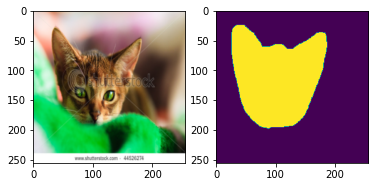

In [ ]:
sample = train_dataset[0]
print(sample["image"].shape)
print(sample["mask"].shape)

plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

In [234]:
#!apt-get update && apt-get install -y libsndfile1 ffmpeg
#!pip install Cython tensorflow==2.11.0 Pygments==2.6.1 pynini==2.1.5 nemo_toolkit[all]
#!pip install segmentation-models-pytorch
#!pip install torchtext.legacy
#!pip install pytorch-lightning

import os
import torch
import matplotlib.pyplot as plt
#import torchtext.legacy
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

from pprint import pprint
from torch.utils.data import DataLoader

class SegmentationModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        #self.register_buffer("std", torch.tensor(params["std"]).view(1, 4, 1, 1))
        #self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 4, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image-image.mean())/image.std()
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]
        mask = batch["mask"]

        assert image.ndim == 4
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        loss = self.loss_fn(logits_mask, mask)

        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        #confusion matric
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [235]:
#FPN_ is a fully convolution neural network for image semantic segmentation.
model = SegmentationModel("FPN", "resnet34", in_channels=4, out_classes=1)

In [236]:
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=5,
)

trainer.fit(
    model, 
    train_dataloaders=train_dl, 
    val_dataloaders=val_dl,
)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total pa

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

OSError: ignored

In [226]:
valid_metrics = trainer.validate(model, dataloaders= val_dl, verbose=False)
pprint(valid_metrics)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

[{'valid_dataset_iou': 0.2779806852340698,
  'valid_per_image_iou': 0.25000497698783875}]


In [227]:
test_metrics = trainer.validate(model, dataloaders= test_dl, verbose=False)
pprint(test_metrics)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

[{'valid_dataset_iou': 0.7726815938949585,
  'valid_per_image_iou': 0.6014060378074646}]


tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]], dtype=torch.uint8)
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
/content/drive/MyDrive/Colab Notebooks/ZAITRA/DATA/images_patches/img_103_patch_9.npy
/content/drive/MyDrive/Colab Notebooks/ZAITRA/DATA/masks_patches/mask_103_patch_1.npy


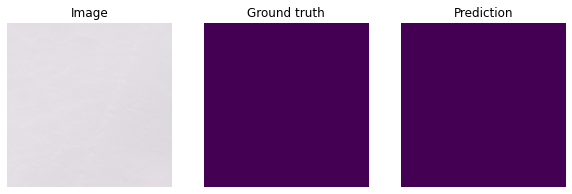

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
/content/drive/MyDrive/Colab Notebooks/ZAITRA/DATA/images_patches/img_103_patch_12.npy
/content/drive/MyDrive/Colab Notebooks/ZAITRA/DATA/masks_patches/mask_100_patch_8.npy


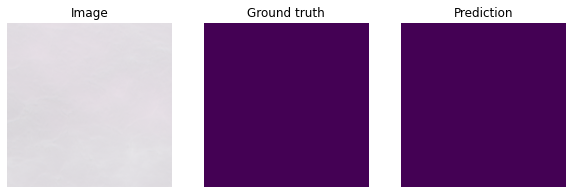

tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]], dtype=torch.uint8)
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
/content/drive/MyDrive/Colab Notebooks/ZAITRA/DATA/images_patches/img_0_patch_8.npy
/content/drive/MyDrive/Colab Notebooks/ZAITRA/DATA/masks_patches/mask_0_patch_10.npy


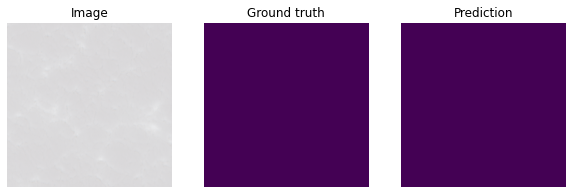

tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]], dtype=torch.uint8)
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
/content/drive/MyDrive/Colab Notebooks/ZAITRA/DATA/images_patches/img_103_patch_3.npy
/content/drive/MyDrive/Colab Notebooks/ZAITRA/DATA/masks_patches/mask_102_patch_8.npy


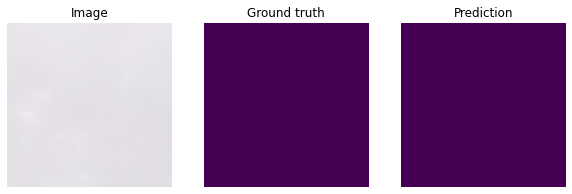

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
/content/drive/MyDrive/Colab Notebooks/ZAITRA/DATA/images_patches/img_102_patch_14.npy
/content/drive/MyDrive/Colab Notebooks/ZAITRA/DATA/masks_patches/mask_100_patch_6.npy


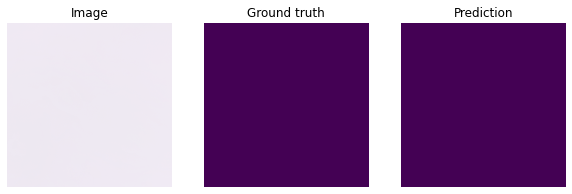

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
/content/drive/MyDrive/Colab Notebooks/ZAITRA/DATA/images_patches/img_104_patch_13.npy
/content/drive/MyDrive/Colab Notebooks/ZAITRA/DATA/masks_patches/mask_104_patch_4.npy


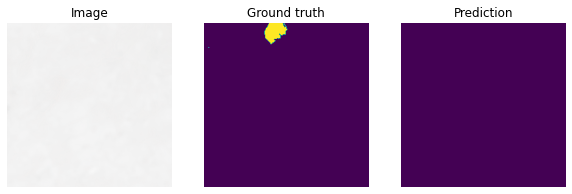

In [230]:
batch = next(iter(val_dl))

with torch.no_grad():
    model.eval()
    logits = model(batch["image"])

pr_masks = logits.sigmoid()


for image, gt_mask, pr_mask, image_path, mask_path in zip(batch["image"], batch["mask"], pr_masks, batch["imagePath"],batch["maskPath"]):
    print(gt_mask)
    print(torch.round(pr_mask))
    
    print(image_path)
    print(mask_path)
    
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(torch.round(pr_mask).numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()